In [86]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import pandas as pd
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import albumentations as A
import cv2
import glob
import os
import shapely.geometry as sg
import shapely.ops as so
import colorsys
import requests
import glob
import samgeo
import leafmap

from tqdm import tqdm
from shapely import wkt
from shapely.geometry import mapping, Polygon, box

from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
from rasterio.plot import show
from rasterio.mask import mask
from transformers import ViTModel
from osgeo import gdal
from transformers import ViTForImageClassification, ViTImageProcessor
from os import listdir
from os.path import isfile, join
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

Notes:


- Used the following instead of pip conda install -c huggingface -c conda-forge datasets

### Data Prep

### Create Transformations

Below is the code for transformations related to crop/rotation, colour/saturation, and brightness on training data. It also normalise both train and test data with image net mean and std deviation. Finally, we convert the data to PyTorch tensor using ToTensor().

In [ ]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
os.getcwd()

'/Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models'

In [4]:
print("Current Path : ", os.getcwd())
os.chdir('../..')
print("Current Path : ", os.getcwd())

Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/src/04_models
Current Path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio


In [5]:
ROOT_DIR=os.getcwd()
BASE_DATA_DIR = os.path.join(ROOT_DIR, 'data')
print("BASE_DIR : ", BASE_DATA_DIR)
DATA_DIR = os.path.join(BASE_DATA_DIR, 'xview_building_damage/train/sample')
print("DATA_DIR : ", DATA_DIR)
SAM_CKPT_DIR=os.path.join(BASE_DATA_DIR, 'utils')
print("SAM_CKPT_DIR : ", SAM_CKPT_DIR)
metadata_csv_path=os.path.join(BASE_DATA_DIR, 'xview_building_damage/train/xview2_processed.csv')
print("Metadata File path : ",metadata_csv_path )
MASK_OUTPUT_DIR=os.path.join(DATA_DIR,'hurricane-florence/sam_masks')

BASE_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data
DATA_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/sample
SAM_CKPT_DIR :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/utils
Metadata File path :  /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/xview2_processed.csv


### Load the metadatafile

In [6]:
metadata_df=pd.read_csv(metadata_csv_path)
metadata_df.head()

,sensor,provider_asset_type,gsd,capture_date,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,...,img_name,map_polygon,building_id,image_polygon,feature_type,damage,dataset,image_id,is_pre_image,is_post_image
0,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,...,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83554484998086 14.43845885230631...,88703461-a33d-4327-9244-a0d4e2242ede,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
1,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,...,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83658244456636 14.43748886352666...,e168e405-3479-44ee-849a-7af2ed32dee1,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test,guatemala-volcano_00000003,False,True
2,WORLDVIEW03_VNIR,WORLDVIEW03_VNIR,1.408524,2018-06-22 16:55:40+00:00,21.97336,0.351739,58.571484,71.182274,314.29373,guatemala-volcano,...,guatemala-volcano_00000003_post_disaster.png,POLYGON ((-90.83487803042956 14.43776515972186...,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test,guatemala-volcano_00000003,False,True
3,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,...,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05237408501472 33.58644838741007...,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test,hurricane-florence_00000005,False,True
4,GEOEYE01,GEOEYE01,2.895928,2018-09-18 16:32:47+00:00,41.74134,0.722669,162.699550,57.024815,69.02214,hurricane-florence,...,hurricane-florence_00000005_post_disaster.png,POLYGON ((-79.05057793741786 33.58642007435035...,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test,hurricane-florence_00000005,False,True


#### Filtering metadata to train, test and filtering for Hurricane Florence

In [13]:
all_metadata=metadata_df[['img_name', 'image_polygon','map_polygon', 'damage', 'building_id','disaster_type','disaster','is_post_image','dataset','width','height']]

train_metadata = all_metadata.loc[all_metadata['dataset'] == 'train']
test_metadata = all_metadata.loc[all_metadata['dataset'] == 'test' ]
print("All disaster train records : ",len(train_metadata.index))
print("All disaster test records : ",len(test_metadata.index))

train_hurricane_metadata = train_metadata.loc[train_metadata['disaster'].isin(['hurricane-florence'])]
test_hurricane_metadata = test_metadata.loc[test_metadata['disaster'].isin(['hurricane-florence'])]


# train_hurricane_metadata = train_metadata.loc[train_metadata['disaster'].isin(['hurricane-florence', 'hurricane-harvey', 'hurricane-michael','hurricane-matthew'])]
# test_hurricane_metadata = test_metadata.loc[test_metadata['disaster'].isin(['hurricane-florence', 'hurricane-harvey', 'hurricane-michael','hurricane-matthew'])]
print("================================================ ")
print("Hurricane disaster train records : ",len(train_hurricane_metadata.index))
print("Hurricane disaster test records : ",len(test_hurricane_metadata.index))

annotations=train_hurricane_metadata.groupby('img_name')['image_polygon'].apply(list).reset_index()
polygons = annotations['image_polygon']


All disaster train records :  326606
All disaster test records :  110086
Hurricane disaster train records :  12918
Hurricane disaster test records :  4546


### Helper Methods

In [7]:
def get_centroid(image_wkt):
    pnt= wkt.loads(image_wkt)
    return pnt.centroid.coords[0]

In [8]:
def get_bbox(image_wkt):
    bounds = wkt.loads(image_wkt).bounds
    return box(bounds[0], bounds[1], bounds[2], bounds[3], ccw= True)

def get_bounds_list(image_wkt):
    bounds = wkt.loads(image_wkt).bounds
    return [bounds[0], bounds[1], bounds[2], bounds[3]]


In [9]:
def generate_point_mask_sam(img_wkt):
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(sample_image)
    
    input_point = np.array([list(get_centroid(img_wkt))])
    input_label = np.array([1])
    
    masks, scores, logits = mask_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
    )
    return masks, scores, logits

In [10]:
def generate_bbox_mask_sam(img_wkt):
    mask_predictor = SamPredictor(sam)
    mask_predictor.set_image(sample_image)
    
    masks, scores, logits = mask_predictor.predict(
    box= get_bbox(img_wkt),
    multimask_output=True,
    )
    return masks, scores, logits

In [11]:
def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(5, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

In [14]:
train_hurricane_metadata[train_hurricane_metadata.img_name == 'hurricane-florence_00000008_pre_disaster.png']['image_polygon'].iloc[4]

'POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))'

In [15]:
train_hurricane_metadata[train_hurricane_metadata.img_name == 'hurricane-florence_00000008_pre_disaster.png']['map_polygon'].iloc[4]

'POLYGON ((-79.04459649807326 33.65463574405655, -79.04442861452175 33.6545105395461, -79.0443607641207 33.65456276785402, -79.04433831315851 33.65454557625466, -79.04428512127575 33.65459107839318, -79.04447176420324 33.65473876788495, -79.04459649807326 33.65463574405655))'

In [ ]:
def extract_bboxes(mask):
    """Compute bounding boxes from masks.
    mask: [height, width, num_instances]. Mask pixels are either 1 or 0.

    Returns: bbox array [num_instances, (y1, x1, y2, x2)].
    """
    boxes = np.zeros([mask.shape[-1], 4], dtype=np.int32)
    for i in range(mask.shape[-1]):
        m = mask[:, :, i]
        # Bounding box.
        horizontal_indicies = np.where(np.any(m, axis=0))[0]
        vertical_indicies = np.where(np.any(m, axis=1))[0]
        if horizontal_indicies.shape[0]:
            x1, x2 = horizontal_indicies[[0, -1]]
            y1, y2 = vertical_indicies[[0, -1]]
            # x2 and y2 should not be part of the box. Increment by 1.
            x2 += 1
            y2 += 1
        else:
            # No mask for this instance. Might happen due to
            # resizing or cropping. Set bbox to zeros
            x1, x2, y1, y2 = 0, 0, 0, 0
        boxes[i] = np.array([y1, x1, y2, x2])
    return boxes.astype(np.int32)

### General Segment Anything Model

In [16]:
sam_checkpoint = os.path.join(SAM_CKPT_DIR,"sam_vit_h_4b8939.pth")
model_type = "vit_h"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [17]:
sample_image = cv2.imread(os.path.join(DATA_DIR,'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png'))
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

img_wkt='POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))'
masks, scores, logits = generate_point_mask_sam(img_wkt)
save_mask(masks[np.argmax(scores)],MASK_OUTPUT_DIR+'hurricane-florence_00000008_pre_disaster.png')


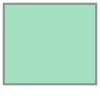

In [18]:
poly= wkt.loads('POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))')
bounds = poly.bounds
box(bounds[0], bounds[1], bounds[2], bounds[3], ccw= True)

In [ ]:
# sample_image = cv2.imread(DATA_DIR+'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png')
# sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
# img_wkt='POLYGON ((281.0476093321693 901.1731423407048, 315.5467743988966 930.7864763428433, 329.0194849627724 917.9062089219493, 333.6350931532248 921.9746513295001, 344.1762843471327 910.7757868407904, 305.7833194500403 875.8008068063064, 281.0476093321693 901.1731423407048))'
# masks, scores, logits = generate_bbox_mask_sam(img_wkt)
# save_mask(masks[np.argmax(scores)],MASK_OUTPUT_DIR+'hurricane-florence_00000008_pre_disaster.png')

#### Generating Individual Masks for Hurricane-florence - Using General SAM

- Tried using general SAM for generating Mask and it did not do a great Job.
- Mask generated were of not good quality
- So Switching to a pre-trained version of SAM - Segement Anything Geo Module

In [19]:
def generate_and_save_mask_by_disaster(data_dir, disaster_name,  annotations, meta_file, mask_output_dir):
    image_files_list = list(annotations['img_name'])

    for img_name in image_files_list:
        sample_image = cv2.imread(data_dir + disaster_name + '/images/'+ img_name)
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        images_df = meta_file[meta_file['img_name'] == img_name]
        for idx, img_df in enumerate(images_df['image_polygon']):
            masks, scores, logits = generate_point_mask_sam(img_df)
            mask_name = img_name.strip('.png')+'_'+images_df.iloc[idx]['building_id']+'.png'
            save_mask(masks[np.argmax(scores)],mask_output_dir+mask_name)
    print("Finished mask creation for disaster ",  disaster_name)       

In [ ]:
generate_and_save_mask_by_disaster(DATA_DIR,'hurricane-florence',annotations, train_hurricane_metadata, MASK_OUTPUT_DIR)

### Segment Anything GEO MODULE

In [71]:
#Sample map_wkt
map_wkt='POLYGON ((-79.04459649807326 33.65463574405655, -79.04442861452175 33.6545105395461, -79.0443607641207 33.65456276785402, -79.04433831315851 33.65454557625466, -79.04428512127575 33.65459107839318, -79.04447176420324 33.65473876788495, -79.04459649807326 33.65463574405655))'

sample_image = cv2.imread(os.path.join(DATA_DIR,'hurricane-florence/images/hurricane-florence_00000008_pre_disaster.png'))
# Converting the image to tif model
sample_image_tif=cv2.imwrite(os.path.join(DATA_DIR,'hurricane-florence/tifs/hurricane-florence_00000008_pre_disaster.tif'),sample_image)
image=os.path.join(DATA_DIR,'hurricane-florence/tifs/hurricane-florence_00000008_pre_disaster.tif')

tms_to_geotiff(output=image, bbox=get_bounds_list(map_wkt), zoom=20, source='SATELLITE', crs='EPSG:3857', overwrite=True)

sam_geo = SamGeo(
    checkpoint=sam_checkpoint,
    model_type=model_type,
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

Downloaded image 1/4
Downloaded image 2/4
Downloaded image 3/4
Downloaded image 4/4
Saving GeoTIFF. Please wait...
Image saved to /Users/yaminigotimukul/DataScience/Berekley/Semesters/Spring_2024/repo/alivio/data/xview_building_damage/train/sample/hurricane-florence/tifs/hurricane-florence_00000008_pre_disaster.tif


### Loading the Leaf Map with the Segmentation for a sample building

In [72]:
cent = get_centroid(map_wkt)
m = leafmap.Map(center=[cent[0], cent[1]], zoom=19)
m.add_basemap("SATELLITE")
m.layers[-1].visible = False  # turn off the basemap
m.add_raster(image, layer_name="Image")
m

Map(center=[-79.04444385070549, 33.65462096649966], controls=(ZoomControl(options=['position', 'zoom_in_text',…

#### Segment the image


Generate the Mask for and input image and saves it in the output directory

In [74]:
output_dir = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/masks','hurricane-florence_00000008_pre_disaster.tif' )

sam_geo.generate(
    output=output_dir, source=image, batch=True, foreground=True, erosion_kernel=(3, 3), mask_multiplier=255
)

100%|█████████████████████████████████████████████| 1/1 [00:30<00:00, 30.46s/it]


#### Polygonize the raster data

In [75]:
vector = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/geo_pkgs','hurricane-florence_00000008_pre_disaster.gpkg' )
sam_geo.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

#### Generate the shape file

In [49]:
shapefile = os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/shape_files','hurricane-florence_00000008_pre_disaster.shp' )
sam_geo.tiff_to_vector(mask, shapefile)

#### Visualize the results

In [76]:
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(vector, layer_name="Vector", style=style)
m

Map(bottom=26885679.0, center=[33.654624999999996, -79.04444050000001], controls=(ZoomControl(options=['positi…

## Model - VIT (Vision Transformer)

The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. Note that there have been made some improvements already (such as DeiT by Facebook AI = Data Efficient Image Transformers), which I also ported to HuggingFace Transformers.

Each image is split into a sequence of non-overlapping patches (of resolutions like 16x16 or 32x32), which are linearly embedded. This is also known as a convolution operation according to some ;) next, absolute position embeddings are added, and sent through a stack of encoder layers. A [CLS] token is added at the beginning in order to get a representation of the entire image. A linear classification head can be added on top of the final hidden state in order to classify images.

### Loading the Vision Transformer

In [29]:
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

{'compression': 'tiff_adobe_deflate', 'dpi': (1, 1), 'resolution': (1, 1)}


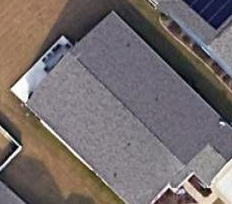

In [79]:
aws_env = False
loaded_image =  None
sample_image_path=os.path.join(ROOT_DIR,'data/xview_building_damage/train/sam_geo/masks','hurricane-florence_00000008_pre_disaster.tif')
if aws_env:
    url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
    loaded_image = Image.open(requests.get(url, stream=True).raw)
else:
    loaded_image = Image.open(image)

print(loaded_image.info)
loaded_image


In [81]:
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
inputs = processor(images=loaded_image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [83]:
print(pixel_values.shape)

torch.Size([1, 3, 224, 224])


### Forward pass

In [84]:
with torch.no_grad():
  outputs = model(pixel_values)
logits = outputs.logits
logits.shape

torch.Size([1, 1000])

In [85]:
prediction = logits.argmax(-1)
print("Predicted class:", model.config.id2label[prediction.item()])

Predicted class: solar dish, solar collector, solar furnace
